## Background
We categorized events by gen level infomartion: boosted, resolved ,semi-boosted, and out of categories (ooc). 

We found most ooc events are in the resolved pT mHH. 

Below is a recap

In [1]:
import numpy as np
import pandas as pd
import vector
import os
import hist
import awkward as ak

vector.register_awkward()

from itertools import permutations

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# mplhep for CMS-style plots
import mplhep as hep

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 16})

In [3]:
def make_vector(events: pd.DataFrame, obj: str):
    """Create a ``vector`` object from the columns of the dataframe"""
    mstring = "Msd" if obj == "ak8FatJet" else "Mass"

    return vector.array(
        {
            "pt": events[f"{obj}Pt"],
            "phi": events[f"{obj}Phi"],
            "eta": events[f"{obj}Eta"],
            "M": events[f"{obj}{mstring}"],
        }
    )

In [4]:
events = pd.read_parquet(
    "/eos/uscms/store/user/cmantill/bbbb/matching/Oct2/2018/GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8/parquet"
)

In [5]:
events = pd.read_parquet(
    "/eos/uscms/store/user/cmantill/bbbb/matching/Oct30/2018/GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8/parquet/"
)

In [6]:
jets = make_vector(events, "ak4Jet")
gen_higgs = make_vector(events, "GenHiggs")
gen_bs = make_vector(events, "Genb")
fjs = make_vector(events, "ak8FatJet")

In [7]:
list(events.keys())

[('ht', 0),
 ('GenHiggsEta', 0),
 ('GenHiggsEta', 1),
 ('GenHiggsPhi', 0),
 ('GenHiggsPhi', 1),
 ('GenHiggsMass', 0),
 ('GenHiggsMass', 1),
 ('GenHiggsPt', 0),
 ('GenHiggsPt', 1),
 ('GenbEta', 0),
 ('GenbEta', 1),
 ('GenbEta', 2),
 ('GenbEta', 3),
 ('GenbPhi', 0),
 ('GenbPhi', 1),
 ('GenbPhi', 2),
 ('GenbPhi', 3),
 ('GenbMass', 0),
 ('GenbMass', 1),
 ('GenbMass', 2),
 ('GenbMass', 3),
 ('GenbPt', 0),
 ('GenbPt', 1),
 ('GenbPt', 2),
 ('GenbPt', 3),
 ('ak4JetHiggsMatch', 0),
 ('ak4JetHiggsMatch', 1),
 ('ak4JetHiggsMatch', 2),
 ('ak4JetHiggsMatch', 3),
 ('ak4JetHiggsMatch', 4),
 ('ak4JetHiggsMatch', 5),
 ('ak4JetHiggsMatchIndex', 0),
 ('ak4JetHiggsMatchIndex', 1),
 ('ak4JetHiggsMatchIndex', 2),
 ('ak4JetHiggsMatchIndex', 3),
 ('ak4JetHiggsMatchIndex', 4),
 ('ak4JetHiggsMatchIndex', 5),
 ('ak4JethadronFlavour', 0),
 ('ak4JethadronFlavour', 1),
 ('ak4JethadronFlavour', 2),
 ('ak4JethadronFlavour', 3),
 ('ak4JethadronFlavour', 4),
 ('ak4JethadronFlavour', 5),
 ('ak8FatJetHiggsMatch', 0),
 ('

In [8]:
drbh1ak8 = events["ak8FatJetMaxdRH1"].to_numpy()
drbh2ak8 = events["ak8FatJetMaxdRH2"].to_numpy()
indexak8 = events["ak8FatJetHiggsMatchIndex"].to_numpy()
indexak4 = events["ak4JetHiggsMatchIndex"].to_numpy()
nbh1ak8 = events["ak8FatJetNumBMatchedH1"].to_numpy()
nbh2ak8 = events["ak8FatJetNumBMatchedH2"].to_numpy()

In [9]:
# ak4 jets matched to h1 and h2
h1ak4 = indexak4 == 0
h2ak4 = indexak4 == 1
num_ak4m2h1 = h1ak4.sum(axis=1)
num_ak4m2h2 = h2ak4.sum(axis=1)
h1m2ak4 = num_ak4m2h1 == 2
h2m2ak4 = num_ak4m2h2 == 2

# ak8 jets matched to h1 and h2
h1ak8 = indexak8 == 0
h2ak8 = indexak8 == 1
num_ak8m2h1 = h1ak8.sum(axis=1)
num_ak8m2h2 = h2ak8.sum(axis=1)
h1m1ak8 = num_ak8m2h1 == 1
h2m1ak8 = num_ak8m2h2 == 1

boosted = h1m1ak8 & h2m1ak8
semi_resolved_h1 = h1m2ak4 & h2m1ak8 & ~(boosted)
semi_resolved_h2 = h2m2ak4 & h1m1ak8 & ~(boosted)
semi_resolved = semi_resolved_h1 | semi_resolved_h2
resolved = (h1m2ak4 & h2m2ak4) & ~(boosted) & ~(semi_resolved) & (num_ak8m2h1 == 0) & (num_ak8m2h2 == 0)
not_categorized = ~(resolved | boosted | semi_resolved)

In [10]:
h1ak8nb2 = (indexak8 == 0) & (nbh1ak8 == 2)
h2ak8nb2 = (indexak8 == 1) & (nbh2ak8 == 2)
h1m1ak8b2 = h1ak8nb2.sum(axis=1) == 1
h2m1ak8b2 = h2ak8nb2.sum(axis=1) == 1

h1ak8nb1 = (indexak8 == 0) & (nbh1ak8 == 1)
h2ak8nb1 = (indexak8 == 1) & (nbh2ak8 == 1)
h1m1ak8b1 = h1ak8nb1.sum(axis=1) == 1
h2m1ak8b1 = h2ak8nb1.sum(axis=1) == 1

boosted_nb2 = h1m1ak8b2 & h2m1ak8b2
boosted_nb1 = h1m1ak8b1 & h2m1ak8b1
boosted_nb1nb2 = (h1m1ak8b1 & h2m1ak8b2) | (h1m1ak8b2 & h2m1ak8b1)

In [11]:
semi_resolved_h1_b2 = h1m2ak4 & (h2m1ak8b2 & ~h2m2ak4) & ~(resolved) & ~(boosted)
semi_resolved_h2_b2 = h2m2ak4 & (h1m1ak8b2 & ~h1m2ak4) & ~(resolved) & ~(boosted)
semi_resolved_h1_b1 = h1m2ak4 & (h2m1ak8b1 & ~h2m2ak4) & ~(resolved) & ~(boosted)
semi_resolved_h2_b1 = h2m2ak4 & (h1m1ak8b1 & ~h1m2ak4) & ~(resolved) & ~(boosted)

semi_resolved_h_b2 = semi_resolved_h1_b2 | semi_resolved_h2_b2
semi_resolved_h_b1 = semi_resolved_h1_b1 | semi_resolved_h2_b1

Text(1, 0, '$m_{HH}$')

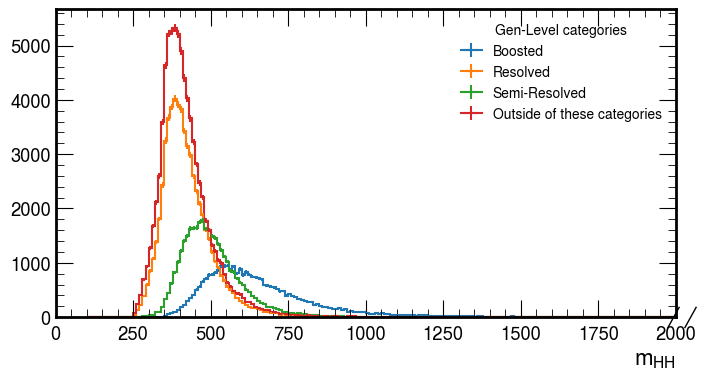

In [12]:
# calcualte m_HH for every event
mhh = (gen_higgs[:, 0] + gen_higgs[:, 1]).m

# bypass into each category
mhh_boosted = mhh[boosted]
mhh_resolved = mhh[resolved]
mhh_semi = mhh[semi_resolved]
mhh_out = mhh[not_categorized]

# start to plot, code modified on Christina's plot_h1h2_fj
bins = np.arange(mhh.min(), mhh.max(), 10)
bins = np.arange(100, 2000, 10)
var_axis = hist.axis.Variable(bins, name="var", label="variable")
cat_axis = hist.axis.StrCategory([], name="cat", growth=True)

hist_mhh = hist.Hist(var_axis, cat_axis)
hist_mhh.fill(var=mhh_boosted, cat="boosted")
hist_mhh.fill(var=mhh_semi, cat="semi_resolved")
hist_mhh.fill(var=mhh_resolved, cat="resolved")
hist_mhh.fill(var=mhh_out, cat="non-categorized")

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
hist_mhh[{"cat": "boosted"}].plot1d(ax=ax, label="Boosted")
hist_mhh[{"cat": "resolved"}].plot1d(ax=ax, label="Resolved")
hist_mhh[{"cat": "semi_resolved"}].plot1d(ax=ax, label="Semi-Resolved")
hist_mhh[{"cat": "non-categorized"}].plot1d(ax=ax, label="Outside of these categories")
leg = ax.legend(fontsize=10)
leg.set_title("Gen-Level categories", prop={"size": 10})
ax.set_xlim(0, 2000)
ax.set_xlabel(r"$m_{HH}$")

## Investigations
### Ak4 matched to b quarks vs. Higgs pT

In [13]:
events_ooc = events[not_categorized]
Hs_ooc = gen_higgs[not_categorized]
js_ooc = jets[not_categorized]

In [14]:
b_m2h1_ooc = gen_bs[not_categorized][:, 0:2]
b_m2h2_ooc = gen_bs[not_categorized][:, 2:4]

In [15]:
# calculate dR(b_quark, jets)
dR_h1b1_js = b_m2h1_ooc[:, 0][:, np.newaxis].deltaR(js_ooc)
dR_h1b2_js = b_m2h1_ooc[:, 1][:, np.newaxis].deltaR(js_ooc)
dR_h2b1_js = b_m2h2_ooc[:, 0][:, np.newaxis].deltaR(js_ooc)
dR_h2b2_js = b_m2h2_ooc[:, 1][:, np.newaxis].deltaR(js_ooc)

# count how many jets are matched to each b
N_jm2b1h1 = ak.sum(dR_h1b1_js < 0.4, axis=-1)
N_jm2b2h1 = ak.sum(dR_h1b2_js < 0.4, axis=-1)
N_jm2b1h2 = ak.sum(dR_h2b1_js < 0.4, axis=-1)
N_jm2b2h2 = ak.sum(dR_h2b2_js < 0.4, axis=-1)

In [16]:
# categorize them into
# 1. exceed: both b1 and b2 matched to more than 1 ak4
# 2. partial_exceed: one of the bs is matched to more than 1 ak4, another is matched to 1 ak4
# 3. polarized: one of the bs is matched to more than 1 ak4, another is unmatched
# 4. match: both b1 and b2 are uniquely matched
# 5. partial_match: only one of the b is uniquely matched, the other is unmatched
# 6. unmatch: no b is matched
h1_exceed = (N_jm2b1h1 > 1) & (N_jm2b2h1 > 1)
h2_exceed = (N_jm2b1h2 > 1) & (N_jm2b2h2 > 1)

h1_partial_exceed = ((N_jm2b1h1 > 1) & (N_jm2b2h1 == 1)) | ((N_jm2b1h1 == 1) & (N_jm2b2h1 > 1))
h2_partial_exceed = ((N_jm2b1h2 > 1) & (N_jm2b2h2 == 1)) | ((N_jm2b1h2 == 1) & (N_jm2b2h2 > 1))

h1_polarized = ((N_jm2b1h1 > 1) & (N_jm2b2h1 == 0)) | ((N_jm2b1h1 == 0) & (N_jm2b2h1 > 1))
h2_polarized = ((N_jm2b1h2 > 1) & (N_jm2b2h2 == 0)) | ((N_jm2b1h2 == 0) & (N_jm2b2h2 > 1))

h1_match = (N_jm2b1h1 == 1) & (N_jm2b2h1 == 1)
h2_match = (N_jm2b1h2 == 1) & (N_jm2b2h2 == 1)

h1_partial_match = ((N_jm2b1h1 == 1) & (N_jm2b2h1 == 0)) | ((N_jm2b1h1 == 0) & (N_jm2b2h1 == 1))
h2_partial_match = ((N_jm2b1h2 == 1) & (N_jm2b2h2 == 0)) | ((N_jm2b1h2 == 0) & (N_jm2b2h2 == 1))

h1_unmatch = (N_jm2b1h1 == 0) & (N_jm2b2h1 == 0)
h2_unmatch = (N_jm2b1h2 == 0) & (N_jm2b2h2 == 0)

In [17]:
# check if the event numbers in each category adds up to total number of events
category_h1 = [h1_exceed, h1_partial_exceed, h1_match, h1_polarized, h1_partial_match, h1_unmatch]
category_h2 = [h2_exceed, h2_partial_exceed, h2_match, h2_polarized, h2_partial_match, h2_unmatch]
category = category_h1 + category_h2

N_tot_running = 0
for cat in category_h1:
    N_tot_running += ak.sum(cat)

print(N_tot_running, events_ooc.shape[0])

81200 81200


In [18]:
ooc_ooc = (
    (~h1_exceed)
    & (~h1_partial_exceed)
    & (~h1_match)
    & (~h1_polarized)
    & (~h1_partial_match)
    & (~h1_unmatch)
)

In [19]:
for Ns in zip(N_jm2b1h1[ooc_ooc], N_jm2b2h1[ooc_ooc], N_jm2b1h2[ooc_ooc], N_jm2b2h2[ooc_ooc]):
    print(Ns)

ak.sum(ooc_ooc)

0

In [20]:
# get pt in each H each category
H1 = Hs_ooc[:, 0]
h1pt_exceed = H1[h1_exceed].pt
h1pt_partial_exceed = H1[h1_partial_exceed].pt
h1pt_polzrized = H1[h1_polarized].pt
h1pt_match = H1[h1_match].pt
h1pt_partial_match = H1[h1_partial_match].pt
h1pt_unmatch = H1[h1_unmatch].pt

In [21]:
H2 = Hs_ooc[:, 1]
h2pt_exceed = H2[h2_exceed].pt
h2pt_partial_exceed = H2[h2_partial_exceed].pt
h2pt_polzrized = H2[h2_polarized].pt
h2pt_match = H2[h2_match].pt
h2pt_partial_match = H2[h2_partial_match].pt
h2pt_unmatch = H2[h2_unmatch].pt

Text(1, 0, '$pT_{H_2}$')

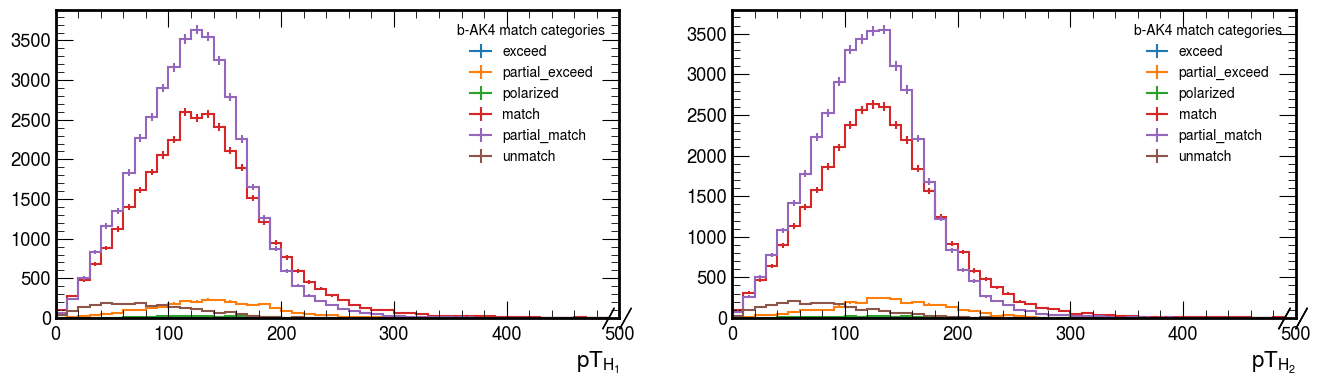

In [22]:
# start to plot
bins = np.arange(0, 500, 10)
var_axis = hist.axis.Variable(bins, name="var", label="variable")
cat_axis = hist.axis.StrCategory([], name="cat", growth=True)

hist_h1pt = hist.Hist(var_axis, cat_axis)
hist_h1pt.fill(var=h1pt_exceed, cat="exceed")
hist_h1pt.fill(var=h1pt_partial_exceed, cat="partial_exceed")
hist_h1pt.fill(var=h1pt_polzrized, cat="polarized")
hist_h1pt.fill(var=h1pt_match, cat="match")
hist_h1pt.fill(var=h1pt_partial_match, cat="partial_match")
hist_h1pt.fill(var=h1pt_unmatch, cat="unmatch")

hist_h2pt = hist.Hist(var_axis, cat_axis)
hist_h2pt.fill(var=h2pt_exceed, cat="exceed")
hist_h2pt.fill(var=h2pt_partial_exceed, cat="partial_exceed")
hist_h2pt.fill(var=h2pt_polzrized, cat="polarized")
hist_h2pt.fill(var=h2pt_match, cat="match")
hist_h2pt.fill(var=h2pt_partial_match, cat="partial_match")
hist_h2pt.fill(var=h2pt_unmatch, cat="unmatch")


fig, ax = plt.subplots(1, 2, figsize=(16, 4))
hist_h1pt[{"cat": "exceed"}].plot1d(ax=ax[0], label="exceed")
hist_h1pt[{"cat": "partial_exceed"}].plot1d(ax=ax[0], label="partial_exceed")
hist_h1pt[{"cat": "polarized"}].plot1d(ax=ax[0], label="polarized")
hist_h1pt[{"cat": "match"}].plot1d(ax=ax[0], label="match")
hist_h1pt[{"cat": "partial_match"}].plot1d(ax=ax[0], label="partial_match")
hist_h1pt[{"cat": "unmatch"}].plot1d(ax=ax[0], label="unmatch")

hist_h2pt[{"cat": "exceed"}].plot1d(ax=ax[1], label="exceed")
hist_h2pt[{"cat": "partial_exceed"}].plot1d(ax=ax[1], label="partial_exceed")
hist_h2pt[{"cat": "polarized"}].plot1d(ax=ax[1], label="polarized")
hist_h2pt[{"cat": "match"}].plot1d(ax=ax[1], label="match")
hist_h2pt[{"cat": "partial_match"}].plot1d(ax=ax[1], label="partial_match")
hist_h2pt[{"cat": "unmatch"}].plot1d(ax=ax[1], label="unmatch")

leg1 = ax[0].legend(fontsize=10)
leg1.set_title("b-AK4 match categories", prop={"size": 10})
ax[0].set_xlim(0, 500)
ax[0].set_xlabel(r"$pT_{H_1}$")

leg2 = ax[1].legend(fontsize=10)
leg2.set_title("b-AK4 match categories", prop={"size": 10})
ax[1].set_xlim(0, 500)
ax[1].set_xlabel(r"$pT_{H_2}$")

### OOC matching combination statistics

In [23]:
def parse_2d_num_pairs(array, sym=False):
    if sym is True:
        for pair in array:
            print("")
            print(f"One H matched to {pair[0][0]} AK4 jets and {pair[1][0]} AK8 jets")
            print(f"The other H matched to {pair[0][1]} AK4 jets and {pair[1][1]} AK8 jets")
    else:
        for pair in array:
            print("")
            print(f"H1 matched to {pair[0][0]} AK4 jets and {pair[1][0]} AK8 jets")
            print(f"H2 matched to {pair[0][1]} AK4 jets and {pair[1][1]} AK8 jets")

    return

In [24]:
# e.g. number of ak4 jets matched to h1 and h2 for non-categorized events
num_ak4N8m2h_nc = (
    np.stack(
        [
            num_ak4m2h1[not_categorized],
            num_ak4m2h2[not_categorized],
            num_ak8m2h1[not_categorized],
            num_ak8m2h2[not_categorized],
        ],
        axis=1,
    )
    .reshape(-1, 2, 2)
    .tolist()
)

# store all recorded combinations of [[num_ak4m2H1, num_ak4m2H2], [num_ak8m2H1, num_ak8m2H2]]
pair_ak4N8m2h_nc = []

# loop from all num pairs constructed from the ooc events
for pair in num_ak4N8m2h_nc:
    if pair not in pair_ak4N8m2h_nc:
        pair_ak4N8m2h_nc.append(pair)

parse_2d_num_pairs(pair_ak4N8m2h_nc)


H1 matched to 2 AK4 jets and 0 AK8 jets
H2 matched to 1 AK4 jets and 0 AK8 jets

H1 matched to 1 AK4 jets and 1 AK8 jets
H2 matched to 1 AK4 jets and 0 AK8 jets

H1 matched to 1 AK4 jets and 0 AK8 jets
H2 matched to 2 AK4 jets and 0 AK8 jets

H1 matched to 1 AK4 jets and 0 AK8 jets
H2 matched to 1 AK4 jets and 0 AK8 jets

H1 matched to 2 AK4 jets and 1 AK8 jets
H2 matched to 1 AK4 jets and 0 AK8 jets

H1 matched to 1 AK4 jets and 0 AK8 jets
H2 matched to 2 AK4 jets and 1 AK8 jets

H1 matched to 1 AK4 jets and 0 AK8 jets
H2 matched to 1 AK4 jets and 1 AK8 jets

H1 matched to 2 AK4 jets and 0 AK8 jets
H2 matched to 3 AK4 jets and 0 AK8 jets

H1 matched to 2 AK4 jets and 0 AK8 jets
H2 matched to 0 AK4 jets and 0 AK8 jets

H1 matched to 0 AK4 jets and 0 AK8 jets
H2 matched to 2 AK4 jets and 0 AK8 jets

H1 matched to 3 AK4 jets and 0 AK8 jets
H2 matched to 2 AK4 jets and 0 AK8 jets

H1 matched to 0 AK4 jets and 0 AK8 jets
H2 matched to 2 AK4 jets and 1 AK8 jets

H1 matched to 3 AK4 jets an

In [25]:
print(
    num_ak4m2h1[not_categorized][0:3],
    num_ak4m2h2[not_categorized][0:3],
    num_ak8m2h1[not_categorized][0:3],
    num_ak8m2h2[not_categorized][0:3],
)

[2 2 1] [1 1 1] [0 0 1] [0 0 0]


In [26]:
np.stack(
    [
        num_ak4m2h1[not_categorized][0:3],
        num_ak4m2h2[not_categorized][0:3],
        num_ak8m2h1[not_categorized][0:3],
        num_ak8m2h2[not_categorized][0:3],
    ],
    axis=1,
)

array([[2, 1, 0, 0],
       [2, 1, 0, 0],
       [1, 1, 1, 0]])

In [27]:
np.stack(
    [
        num_ak4m2h1[not_categorized][0:3],
        num_ak4m2h2[not_categorized][0:3],
        num_ak8m2h1[not_categorized][0:3],
        num_ak8m2h2[not_categorized][0:3],
    ],
    axis=1,
).reshape(-1, 2, 2).tolist()

[[[2, 1], [0, 0]], [[2, 1], [0, 0]], [[1, 1], [1, 0]]]

In [28]:
# This cell is tryig to assume H1 and H2 is symmetric
# e.g. num_ak4m2HX = (2, 1) == (1, 2)
# the point is to not differentiate H1 and H2
# note that if ak4 pair is permutated, then ak8 pair should be permutated in the same way

# store all permutations of the recorded combinations of [[num_ak4m2H1, num_ak4m2H2], [num_ak8m2H1, num_ak8m2H2]]
perm_pair_ak4N8m2h_nc = []
# store unique combinations of [num_ak4m2HX, num_ak8m2HX]
unique_pair_ak4N8m2h_nc = []

# loop from all num pairs constructed from the ooc events
for pair in num_ak4N8m2h_nc:
    # if it doesn't match any permutation of the recorded unique pair
    if pair not in perm_pair_ak4N8m2h_nc:
        # add to the unique pair
        unique_pair_ak4N8m2h_nc.append(pair)
        # also add its permutations to the permutation list
        perm_pair_ak4N8m2h_nc.append(pair)
        perm_pair_ak4N8m2h_nc.append([pair[0][::-1], pair[1][::-1]])

parse_2d_num_pairs(unique_pair_ak4N8m2h_nc, sym=True)


One H matched to 2 AK4 jets and 0 AK8 jets
The other H matched to 1 AK4 jets and 0 AK8 jets

One H matched to 1 AK4 jets and 1 AK8 jets
The other H matched to 1 AK4 jets and 0 AK8 jets

One H matched to 1 AK4 jets and 0 AK8 jets
The other H matched to 1 AK4 jets and 0 AK8 jets

One H matched to 2 AK4 jets and 1 AK8 jets
The other H matched to 1 AK4 jets and 0 AK8 jets

One H matched to 2 AK4 jets and 0 AK8 jets
The other H matched to 3 AK4 jets and 0 AK8 jets

One H matched to 2 AK4 jets and 0 AK8 jets
The other H matched to 0 AK4 jets and 0 AK8 jets

One H matched to 0 AK4 jets and 0 AK8 jets
The other H matched to 2 AK4 jets and 1 AK8 jets

One H matched to 3 AK4 jets and 0 AK8 jets
The other H matched to 1 AK4 jets and 1 AK8 jets

One H matched to 3 AK4 jets and 0 AK8 jets
The other H matched to 0 AK4 jets and 0 AK8 jets

One H matched to 2 AK4 jets and 1 AK8 jets
The other H matched to 3 AK4 jets and 0 AK8 jets

One H matched to 1 AK4 jets and 0 AK8 jets
The other H matched to 0 A

In [29]:
print(unique_pair_ak4N8m2h_nc)

[[[2, 1], [0, 0]], [[1, 1], [1, 0]], [[1, 1], [0, 0]], [[2, 1], [1, 0]], [[2, 3], [0, 0]], [[2, 0], [0, 0]], [[0, 2], [0, 1]], [[3, 1], [0, 1]], [[3, 0], [0, 0]], [[2, 3], [1, 0]], [[1, 0], [0, 0]], [[3, 1], [0, 0]], [[3, 1], [1, 0]], [[3, 3], [0, 0]], [[0, 0], [0, 0]], [[1, 0], [0, 1]], [[0, 3], [0, 1]], [[4, 1], [0, 1]], [[4, 1], [0, 0]], [[1, 0], [1, 0]], [[2, 2], [2, 0]], [[3, 3], [0, 1]], [[2, 1], [1, 2]], [[1, 3], [1, 2]], [[4, 2], [0, 0]], [[1, 1], [1, 2]], [[1, 1], [0, 2]], [[0, 0], [1, 0]], [[0, 1], [0, 2]], [[3, 2], [2, 1]], [[1, 2], [0, 2]], [[3, 0], [0, 1]], [[4, 2], [0, 1]], [[1, 3], [0, 2]], [[2, 0], [2, 0]], [[1, 4], [0, 1]], [[4, 0], [0, 0]], [[1, 2], [2, 0]]]


In [30]:
# construct a dictionary to store ooc events in each H matching pattern:
LUT = {}
for pair in unique_pair_ak4N8m2h_nc:
    num_ak4m2h1 = pair[0][0]
    num_ak4m2h2 = pair[0][1]
    num_ak8m2h1 = pair[1][0]
    num_ak8m2h2 = pair[1][1]
    LUT[f"{num_ak4m2h1}{num_ak4m2h2}{num_ak8m2h1}{num_ak8m2h2}"] = 0

In [31]:
for num in num_ak4N8m2h_nc:
    num_ak4m2h1 = num[0][0]
    num_ak4m2h2 = num[0][1]
    num_ak8m2h1 = num[1][0]
    num_ak8m2h2 = num[1][1]

    if num in unique_pair_ak4N8m2h_nc:
        LUT[f"{num_ak4m2h1}{num_ak4m2h2}{num_ak8m2h1}{num_ak8m2h2}"] += 1
    else:
        LUT[f"{num_ak4m2h2}{num_ak4m2h1}{num_ak8m2h2}{num_ak8m2h1}"] += 1

In [32]:
labels_pie = np.array(list(LUT.keys()))
ys_pie = np.array(list(LUT.values()))
labels_pie = labels_pie[np.argsort(ys_pie)[::-1]]
ys_pie = ys_pie[np.argsort(ys_pie)[::-1]]

In [33]:
print(ys_pie)

[49751 10591  6015  4449  2893  2863  1398  1380   462   432   259   186
   182    87    74    63    26    13    12    12     8     6     6     6
     4     3     3     2     2     2     2     2     1     1     1     1
     1     1]


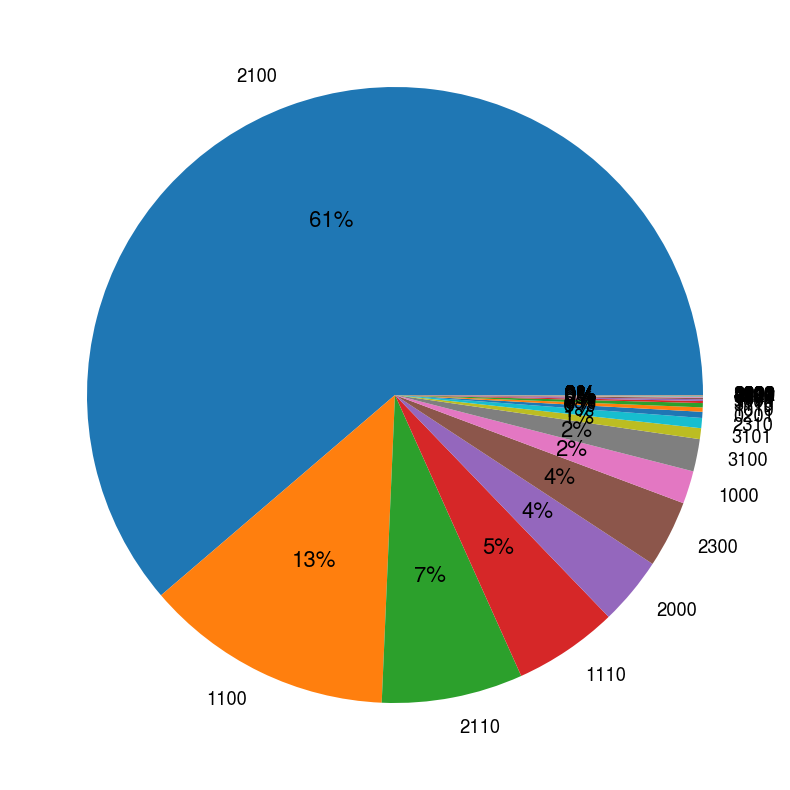

In [34]:
plt.pie(ys_pie, labels=labels_pie, autopct="%1.0f%%")
plt.show()

# Number convention: AK4H1, AK4H2, AK8H1 AK8H2

## Now change matching criteria to recoJet->genJet->genb

In [35]:
genJs = make_vector(events, "ak4GenJet")
genBs = make_vector(events, "Genb")

In [36]:
# dissemble gen_b by H
b_m2h1 = genBs[:,0:2]
b_m2h2 = genBs[:,2:4]

In [37]:
# calculate dR between genb and each genJet
dR_h1b1_genJs = b_m2h1[:, 0][:, np.newaxis].deltaR(genJs)
dR_h1b2_genJs = b_m2h1[:, 1][:, np.newaxis].deltaR(genJs)
dR_h2b1_genJs = b_m2h2[:, 0][:, np.newaxis].deltaR(genJs)
dR_h2b2_genJs = b_m2h2[:, 1][:, np.newaxis].deltaR(genJs)

In [38]:
# count how many jets are matched to each b
GenJm2b1h1 = (dR_h1b1_genJs < 0.4)[:,:, np.newaxis]
GenJm2b2h1 = (dR_h1b2_genJs < 0.4)[:,:, np.newaxis]
GenJm2b1h2 = (dR_h2b1_genJs < 0.4)[:,:, np.newaxis]
GenJm2b2h2 = (dR_h2b2_genJs < 0.4)[:,:, np.newaxis]
print(GenJm2b1h1.shape)

# concatenate the arrays
# 1st dimension: event
# 2nd dimension: GenJ
# 3rd dimension: match to each b true or false
GenJm2b = np.concatenate([GenJm2b1h1, GenJm2b2h1, GenJm2b1h2, GenJm2b2h2], axis=2)
print(GenJm2b.shape)

(208000, 6, 1)
(208000, 6, 4)


In [39]:
# construct ak4GenJet info
ak4GenJetHiggsMatch = np.zeros(shape=genJs.shape, dtype=bool)
ak4GenJetHiggsMatchIndex = -1*np.ones(shape=genJs.shape, dtype=int)

# If a gen J is matched to 1 and only 1 genb, 
# it is considered to be matched to the mother H
# and will be assigned with a ak4GenJetHiggsMatchIndex
GenJm2H = np.sum(GenJm2b, axis=2)==1
ak4GenJetHiggsMatch[GenJm2H] = True

# find which genb and H matched the genJ
# draft in the sense that only the matched genJ's
# genB and genH indices will be used
bIdx_draft = np.argmax(GenJm2b, axis=2)
hIdx_draft = np.floor(bIdx_draft/2)
ak4GenJetHiggsMatchIndex[ak4GenJetHiggsMatch] = hIdx_draft[ak4GenJetHiggsMatch]

### Plotting each categories for the genJ genb matching

In [40]:
indexak8 = events["ak8FatJetHiggsMatchIndex"].to_numpy()
indexak4 = ak4GenJetHiggsMatchIndex

In [41]:
# ak4 jets matched to h1 and h2
h1ak4 = indexak4 == 0
h2ak4 = indexak4 == 1
num_ak4m2h1 = h1ak4.sum(axis=1)
num_ak4m2h2 = h2ak4.sum(axis=1)
h1m2ak4 = num_ak4m2h1 == 2
h2m2ak4 = num_ak4m2h2 == 2

# ak8 jets matched to h1 and h2
h1ak8 = indexak8 == 0
h2ak8 = indexak8 == 1
num_ak8m2h1 = h1ak8.sum(axis=1)
num_ak8m2h2 = h2ak8.sum(axis=1)
h1m1ak8 = num_ak8m2h1 == 1
h2m1ak8 = num_ak8m2h2 == 1

boosted = h1m1ak8 & h2m1ak8
resolved = (h1m2ak4 & h2m2ak4) & ~(boosted) & (num_ak8m2h1 == 0) & (num_ak8m2h2 == 0)
semi_resolved_h1 = h1m2ak4 & h2m1ak8 & ~(resolved) & ~(boosted)
semi_resolved_h2 = h2m2ak4 & h1m1ak8 & ~(resolved) & ~(boosted)
semi_resolved = semi_resolved_h1 | semi_resolved_h2
not_categorized = ~(resolved | boosted | semi_resolved)

In [42]:
h1ak8nb2 = (indexak8 == 0) & (nbh1ak8 == 2)
h2ak8nb2 = (indexak8 == 1) & (nbh2ak8 == 2)
h1m1ak8b2 = h1ak8nb2.sum(axis=1) == 1
h2m1ak8b2 = h2ak8nb2.sum(axis=1) == 1

h1ak8nb1 = (indexak8 == 0) & (nbh1ak8 == 1)
h2ak8nb1 = (indexak8 == 1) & (nbh2ak8 == 1)
h1m1ak8b1 = h1ak8nb1.sum(axis=1) == 1
h2m1ak8b1 = h2ak8nb1.sum(axis=1) == 1

boosted_nb2 = h1m1ak8b2 & h2m1ak8b2
boosted_nb1 = h1m1ak8b1 & h2m1ak8b1
boosted_nb1nb2 = (h1m1ak8b1 & h2m1ak8b2) | (h1m1ak8b2 & h2m1ak8b1)

In [43]:
semi_resolved_h1_b2 = h1m2ak4 & (h2m1ak8b2 & ~h2m2ak4) & ~(resolved) & ~(boosted)
semi_resolved_h2_b2 = h2m2ak4 & (h1m1ak8b2 & ~h1m2ak4) & ~(resolved) & ~(boosted)
semi_resolved_h1_b1 = h1m2ak4 & (h2m1ak8b1 & ~h2m2ak4) & ~(resolved) & ~(boosted)
semi_resolved_h2_b1 = h2m2ak4 & (h1m1ak8b1 & ~h1m2ak4) & ~(resolved) & ~(boosted)

semi_resolved_h_b2 = semi_resolved_h1_b2 | semi_resolved_h2_b2
semi_resolved_h_b1 = semi_resolved_h1_b1 | semi_resolved_h2_b1

Text(1, 0, '$m_{HH}$')

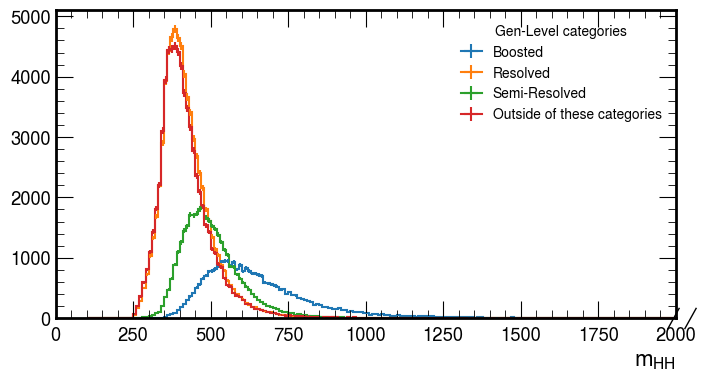

In [44]:
# calcualte m_HH for every event
mhh = (gen_higgs[:, 0] + gen_higgs[:, 1]).m

# bypass into each category
mhh_boosted = mhh[boosted]
mhh_resolved = mhh[resolved]
mhh_semi = mhh[semi_resolved]
mhh_out = mhh[not_categorized]

# start to plot, code modified on Christina's plot_h1h2_fj
bins = np.arange(mhh.min(), mhh.max(), 10)
bins = np.arange(100, 2000, 10)
var_axis = hist.axis.Variable(bins, name="var", label="variable")
cat_axis = hist.axis.StrCategory([], name="cat", growth=True)

hist_mhh = hist.Hist(var_axis, cat_axis)
hist_mhh.fill(var=mhh_boosted, cat="boosted")
hist_mhh.fill(var=mhh_semi, cat="semi_resolved")
hist_mhh.fill(var=mhh_resolved, cat="resolved")
hist_mhh.fill(var=mhh_out, cat="non-categorized")

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
hist_mhh[{"cat": "boosted"}].plot1d(ax=ax, label="Boosted")
hist_mhh[{"cat": "resolved"}].plot1d(ax=ax, label="Resolved")
hist_mhh[{"cat": "semi_resolved"}].plot1d(ax=ax, label="Semi-Resolved")
hist_mhh[{"cat": "non-categorized"}].plot1d(ax=ax, label="Outside of these categories")
leg = ax.legend(fontsize=10)
leg.set_title("Gen-Level categories", prop={"size": 10})
ax.set_xlim(0, 2000)
ax.set_xlabel(r"$m_{HH}$")

###  Mapping genJ to recoJ after having more information in the dataset

In [45]:
# get ak4JetGenJetIdx
# to know genJet recoJet correspondence
ak4JetGenJetIdx = events['ak4JetGenJetIdx'].to_numpy()
not_padded = ak4JetGenJetIdx>0
not_oor = ak4JetGenJetIdx<6 #oor=out of range
select = not_padded & not_oor

In [46]:
ak4JetGenJetIdx_select = ak.mask(ak4JetGenJetIdx, select)
ak4JetGenJetIdx_select = ak.drop_none(ak4JetGenJetIdx_select)

In [47]:
# select the genJet Higgs matching index that genJet also matched to reco jet
ak4GenJetHiggsMatchIndex_ak = ak.Array(ak4GenJetHiggsMatchIndex)
ak4JetHiggsMatchIndex_new = ak4GenJetHiggsMatchIndex_ak[ak4JetGenJetIdx_select]
# because we only care how many reco jet matched to h1 and h2
# the order of reco jet in each event is irrelevant

# pad each event to 6 
ak4JetHiggsMatchIndex_new = ak.fill_none(ak.pad_none(ak4JetHiggsMatchIndex_new, 6, axis=-1), -1).to_numpy()

In [48]:
indexak8 = events["ak8FatJetHiggsMatchIndex"].to_numpy()
indexak4 = ak4JetHiggsMatchIndex_new

In [49]:
# ak4 jets matched to h1 and h2
h1ak4 = indexak4 == 0
h2ak4 = indexak4 == 1
num_ak4m2h1 = h1ak4.sum(axis=1)
num_ak4m2h2 = h2ak4.sum(axis=1)
h1m2ak4 = num_ak4m2h1 == 2
h2m2ak4 = num_ak4m2h2 == 2

# ak8 jets matched to h1 and h2
h1ak8 = indexak8 == 0
h2ak8 = indexak8 == 1
num_ak8m2h1 = h1ak8.sum(axis=1)
num_ak8m2h2 = h2ak8.sum(axis=1)
h1m1ak8 = num_ak8m2h1 == 1
h2m1ak8 = num_ak8m2h2 == 1

boosted = h1m1ak8 & h2m1ak8
semi_resolved_h1 = h1m2ak4 & h2m1ak8 & ~(boosted)
semi_resolved_h2 = h2m2ak4 & h1m1ak8 & ~(boosted)
semi_resolved = semi_resolved_h1 | semi_resolved_h2
resolved = (h1m2ak4 & h2m2ak4) & ~(boosted) & ~(semi_resolved) & (num_ak8m2h1 == 0) & (num_ak8m2h2 == 0)
not_categorized = ~(resolved | boosted | semi_resolved)

In [50]:
h1ak8nb2 = (indexak8 == 0) & (nbh1ak8 == 2)
h2ak8nb2 = (indexak8 == 1) & (nbh2ak8 == 2)
h1m1ak8b2 = h1ak8nb2.sum(axis=1) == 1
h2m1ak8b2 = h2ak8nb2.sum(axis=1) == 1

h1ak8nb1 = (indexak8 == 0) & (nbh1ak8 == 1)
h2ak8nb1 = (indexak8 == 1) & (nbh2ak8 == 1)
h1m1ak8b1 = h1ak8nb1.sum(axis=1) == 1
h2m1ak8b1 = h2ak8nb1.sum(axis=1) == 1

boosted_nb2 = h1m1ak8b2 & h2m1ak8b2
boosted_nb1 = h1m1ak8b1 & h2m1ak8b1
boosted_nb1nb2 = (h1m1ak8b1 & h2m1ak8b2) | (h1m1ak8b2 & h2m1ak8b1)

In [51]:
semi_resolved_h1_b2 = h1m2ak4 & (h2m1ak8b2 & ~h2m2ak4) & ~(resolved) & ~(boosted)
semi_resolved_h2_b2 = h2m2ak4 & (h1m1ak8b2 & ~h1m2ak4) & ~(resolved) & ~(boosted)
semi_resolved_h1_b1 = h1m2ak4 & (h2m1ak8b1 & ~h2m2ak4) & ~(resolved) & ~(boosted)
semi_resolved_h2_b1 = h2m2ak4 & (h1m1ak8b1 & ~h1m2ak4) & ~(resolved) & ~(boosted)

semi_resolved_h_b2 = semi_resolved_h1_b2 | semi_resolved_h2_b2
semi_resolved_h_b1 = semi_resolved_h1_b1 | semi_resolved_h2_b1

Text(1, 0, '$m_{HH}$')

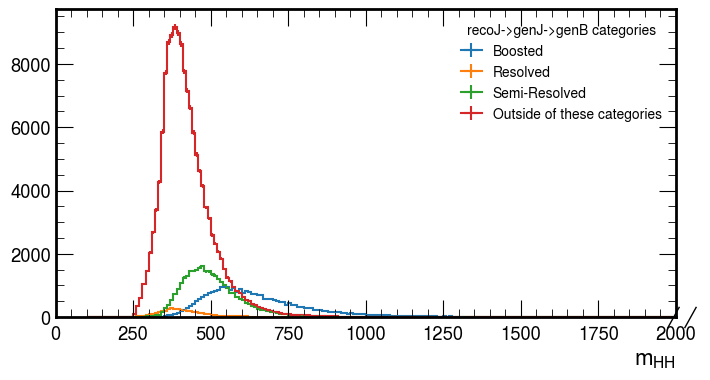

In [52]:
# calcualte m_HH for every event
mhh = (gen_higgs[:, 0] + gen_higgs[:, 1]).m

# bypass into each category
mhh_boosted = mhh[boosted]
mhh_resolved = mhh[resolved]
mhh_semi = mhh[semi_resolved]
mhh_out = mhh[not_categorized]

# start to plot, code modified on Christina's plot_h1h2_fj
bins = np.arange(mhh.min(), mhh.max(), 10)
bins = np.arange(100, 2000, 10)
var_axis = hist.axis.Variable(bins, name="var", label="variable")
cat_axis = hist.axis.StrCategory([], name="cat", growth=True)

hist_mhh = hist.Hist(var_axis, cat_axis)
hist_mhh.fill(var=mhh_boosted, cat="boosted")
hist_mhh.fill(var=mhh_semi, cat="semi_resolved")
hist_mhh.fill(var=mhh_resolved, cat="resolved")
hist_mhh.fill(var=mhh_out, cat="non-categorized")

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
hist_mhh[{"cat": "boosted"}].plot1d(ax=ax, label="Boosted")
hist_mhh[{"cat": "resolved"}].plot1d(ax=ax, label="Resolved")
hist_mhh[{"cat": "semi_resolved"}].plot1d(ax=ax, label="Semi-Resolved")
hist_mhh[{"cat": "non-categorized"}].plot1d(ax=ax, label="Outside of these categories")
leg = ax.legend(fontsize=10)
leg.set_title("recoJ->genJ->genB categories", prop={"size": 10})
ax.set_xlim(0, 2000)
ax.set_xlabel(r"$m_{HH}$")